# Image-to-Image Translation with cGAN (pix2pix)

This notebook implements the pix2pix model using PyTorch for translating images from one domain to another. We will use the 'facades' dataset as an example, translating architectural labels into photorealistic images.

### 1. Setup and Imports
First, we'll import all the necessary libraries. We'll use `torch` and `torchvision` for building the model and handling data, `PIL` for image manipulation, `matplotlib` for plotting, and `numpy`. We also set up the device to use a GPU if one is available.

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob

In [11]:
#Setting device to GPU if available, otherwise CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


### 2. Prepare Dataset from Local Path
This step points to your local dataset directory. We define a custom `Dataset` class to handle loading the data. The class assumes your directory contains `train` and `val`/`test` subfolders. Each image in these folders should be a composite of an architectural label map (left side) and a corresponding photo (right side).

Our dataset class will:
1.  Load the composite image from your specified path.
2.  Split it into the input image (label map) and the target image (photo).
3.  Apply data augmentation and normalization transformations.

In [12]:
root_dir = 'Data/facades' 

class FacadesDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.files = sorted(glob.glob(os.path.join(root_dir, split) + "/*.jpg"))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        image = Image.open(img_path).convert('RGB')
        
        #Splitting image into input and target
        w, h = image.size
        w2 = w // 2
        input_image = image.crop((0, 0, w2, h))
        target_image = image.crop((w2, 0, w, h))

        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)
            
        return input_image, target_image

IMG_SIZE = 256
#Defining transformations
#Resizing to 286x286, then random cropping to 256x256
transform = T.Compose([
    T.Resize((286, 286), T.InterpolationMode.BICUBIC),
    T.RandomCrop(IMG_SIZE),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

train_dataset = FacadesDataset(root_dir=root_dir, split='train', transform=transform)

test_dataset = FacadesDataset(root_dir=root_dir, split='val', transform=transform) 

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

### 3. Define the Generator (U-Net)
The generator is a **U-Net**, which is an encoder-decoder architecture with skip connections. The encoder downsamples the image to extract features, while the decoder upsamples it to construct the output image. The skip connections pass features from the encoder layers directly to the corresponding decoder layers, helping to preserve low-level details.

In [13]:
class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False) if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        #Encoder (Downsampling)
        self.down1 = UNetBlock(in_channels, 64, down=True, act="leaky", use_dropout=False)
        self.down2 = UNetBlock(64, 128, down=True, act="leaky", use_dropout=False)
        self.down3 = UNetBlock(128, 256, down=True, act="leaky", use_dropout=False)
        self.down4 = UNetBlock(256, 512, down=True, act="leaky", use_dropout=False)
        self.down5 = UNetBlock(512, 512, down=True, act="leaky", use_dropout=False)
        self.down6 = UNetBlock(512, 512, down=True, act="leaky", use_dropout=False)
        self.down7 = UNetBlock(512, 512, down=True, act="leaky", use_dropout=False)
        
        #Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 512, 4, 2, 1), nn.ReLU()
        )

        #Decoder (Upsampling) with skip connections
        self.up1 = UNetBlock(512, 512, down=False, act="relu", use_dropout=True)
        self.up2 = UNetBlock(1024, 512, down=False, act="relu", use_dropout=True)
        self.up3 = UNetBlock(1024, 512, down=False, act="relu", use_dropout=True)
        self.up4 = UNetBlock(1024, 512, down=False, act="relu", use_dropout=False)
        self.up5 = UNetBlock(1024, 256, down=False, act="relu", use_dropout=False)
        self.up6 = UNetBlock(512, 128, down=False, act="relu", use_dropout=False)
        self.up7 = UNetBlock(256, 64, down=False, act="relu", use_dropout=False)
        
        #Final layer
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        bottleneck = self.bottleneck(d7)
        u1 = self.up1(bottleneck)
        u2 = self.up2(torch.cat([u1, d7], 1))
        u3 = self.up3(torch.cat([u2, d6], 1))
        u4 = self.up4(torch.cat([u3, d5], 1))
        u5 = self.up5(torch.cat([u4, d4], 1))
        u6 = self.up6(torch.cat([u5, d3], 1))
        u7 = self.up7(torch.cat([u6, d2], 1))
        return self.final_up(torch.cat([u7, d1], 1))

### 4. Define the Discriminator (PatchGAN)
The discriminator is a convolutional **PatchGAN** classifier. It takes both the input image and the target (or generated) image, concatenated together, and determines whether `30x30` overlapping patches of the image are real or fake. This structure encourages the generator to create realistic high-frequency details across the entire image.

In [14]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect"),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        #Input is a concatenation of input_image and target_image, so in_channels*2
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels * 2, 64, kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.conv1 = ConvBlock(64, 128, stride=2)
        self.conv2 = ConvBlock(128, 256, stride=2)
        self.conv3 = ConvBlock(256, 512, stride=1) #Stride is 1 for the last conv block
        self.final = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect")

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return self.final(x)

### 5. Initialize Models, Losses, and Optimizers
Here we initialize the models and move them to the selected device. We define the loss functions: `BCEWithLogitsLoss` for the adversarial component and `L1Loss` for the pixel-wise reconstruction. `L1` loss encourages the generated image to be structurally similar to the target. We also set up Adam optimizers for both networks.

In [15]:
#Hyperparameters
LEARNING_RATE = 2e-4
BETA1 = 0.5
L1_LAMBDA = 100
EPOCHS = 30 #Using a few more epochs for better results

#Model Initialization
gen = Generator().to(device)
disc = Discriminator().to(device)

#Optimizers
opt_gen = torch.optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))

#Loss Functions
bce_loss = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()

### 6. The Training Loop
This is the core of the GAN. For each batch of images:
1.  **Train the Discriminator**: Calculate the loss for real images and fake images separately. The total loss is the average of the two. Backpropagate and update the discriminator's weights.
2.  **Train the Generator**: Calculate the adversarial loss (how well it fools the discriminator) and the L1 reconstruction loss. The total generator loss is a weighted sum of these two losses. Backpropagate and update the generator's weights.

In [16]:
from tqdm import tqdm #For progress bar

gen.train()
disc.train()

for epoch in range(EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{EPOCHS} ---")
    loop = tqdm(train_loader, leave=True)
    for idx, (input_img, target_img) in enumerate(loop):
        input_img, target_img = input_img.to(device), target_img.to(device)

        #Train Discriminator
        fake_img = gen(input_img)
        D_real_pred = disc(input_img, target_img)
        D_real_loss = bce_loss(D_real_pred, torch.ones_like(D_real_pred))
        D_fake_pred = disc(input_img, fake_img.detach())
        D_fake_loss = bce_loss(D_fake_pred, torch.zeros_like(D_fake_pred))
        D_loss = (D_real_loss + D_fake_loss) / 2
        
        opt_disc.zero_grad()
        D_loss.backward()
        opt_disc.step()
        
        #Train Generator
        D_fake_pred = disc(input_img, fake_img)
        G_adv_loss = bce_loss(D_fake_pred, torch.ones_like(D_fake_pred))
        G_l1_loss = l1_loss(fake_img, target_img) * L1_LAMBDA
        G_loss = G_adv_loss + G_l1_loss
        
        opt_gen.zero_grad()
        G_loss.backward()
        opt_gen.step()

        if idx % 200 == 0:
            loop.set_postfix(
                D_real=torch.sigmoid(D_real_pred).mean().item(),
                D_fake=torch.sigmoid(D_fake_pred).mean().item(),
                G_loss=G_loss.item()
            )


--- Epoch 1/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.72it/s, D_fake=0.159, D_real=0.879, G_loss=48.2]



--- Epoch 2/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.66it/s, D_fake=0.00902, D_real=0.984, G_loss=57.8]



--- Epoch 3/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.60it/s, D_fake=0.0155, D_real=0.993, G_loss=57.5]



--- Epoch 4/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.65it/s, D_fake=0.018, D_real=0.995, G_loss=50.1]  



--- Epoch 5/30 ---


100%|██████████| 400/400 [00:14<00:00, 28.54it/s, D_fake=0.186, D_real=0.939, G_loss=69.6] 



--- Epoch 6/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.57it/s, D_fake=0.0667, D_real=0.916, G_loss=62.4]



--- Epoch 7/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.61it/s, D_fake=0.109, D_real=0.99, G_loss=47.4]  



--- Epoch 8/30 ---


100%|██████████| 400/400 [00:14<00:00, 28.55it/s, D_fake=0.00614, D_real=0.992, G_loss=47] 



--- Epoch 9/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.60it/s, D_fake=0.163, D_real=0.93, G_loss=59.3] 



--- Epoch 10/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.59it/s, D_fake=0.00744, D_real=0.997, G_loss=50]  



--- Epoch 11/30 ---


100%|██████████| 400/400 [00:14<00:00, 28.54it/s, D_fake=0.111, D_real=0.998, G_loss=52.9]



--- Epoch 12/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.59it/s, D_fake=0.032, D_real=0.998, G_loss=50.9] 



--- Epoch 13/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.64it/s, D_fake=0.136, D_real=0.997, G_loss=40.6] 



--- Epoch 14/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.61it/s, D_fake=0.037, D_real=0.996, G_loss=67.2] 



--- Epoch 15/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.62it/s, D_fake=0.0986, D_real=0.997, G_loss=64.3]



--- Epoch 16/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.58it/s, D_fake=0.104, D_real=0.752, G_loss=42.2]



--- Epoch 17/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.60it/s, D_fake=0.0835, D_real=0.996, G_loss=48.3]



--- Epoch 18/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.60it/s, D_fake=0.0198, D_real=0.991, G_loss=50.1]



--- Epoch 19/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.58it/s, D_fake=0.152, D_real=0.523, G_loss=45.2]



--- Epoch 20/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.60it/s, D_fake=0.00553, D_real=0.991, G_loss=55] 



--- Epoch 21/30 ---


100%|██████████| 400/400 [00:14<00:00, 28.57it/s, D_fake=0.0815, D_real=0.928, G_loss=39.3] 



--- Epoch 22/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.59it/s, D_fake=0.154, D_real=0.988, G_loss=63.1] 



--- Epoch 23/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.61it/s, D_fake=0.0254, D_real=0.981, G_loss=53.2]



--- Epoch 24/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.62it/s, D_fake=0.0284, D_real=0.0992, G_loss=45.4]



--- Epoch 25/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.61it/s, D_fake=0.11, D_real=0.994, G_loss=69.6] 



--- Epoch 26/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.62it/s, D_fake=0.0197, D_real=0.998, G_loss=51.9]



--- Epoch 27/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.62it/s, D_fake=0.000601, D_real=0.999, G_loss=51.3]



--- Epoch 28/30 ---


100%|██████████| 400/400 [00:14<00:00, 28.56it/s, D_fake=0.0845, D_real=0.954, G_loss=41.4]



--- Epoch 29/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.60it/s, D_fake=0.0681, D_real=0.789, G_loss=36.2]



--- Epoch 30/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.57it/s, D_fake=0.055, D_real=0.998, G_loss=59.2]


### 7. Generate and Display Final Output
After training, we use the generator to translate a few images from our test set. We switch the generator to evaluation mode (`gen.eval()`) and visualize the results. The output shows the **Input** architectural map, the **Generated** photo, and the **Ground Truth** photo side-by-side. This allows for a qualitative assessment of the model's performance.

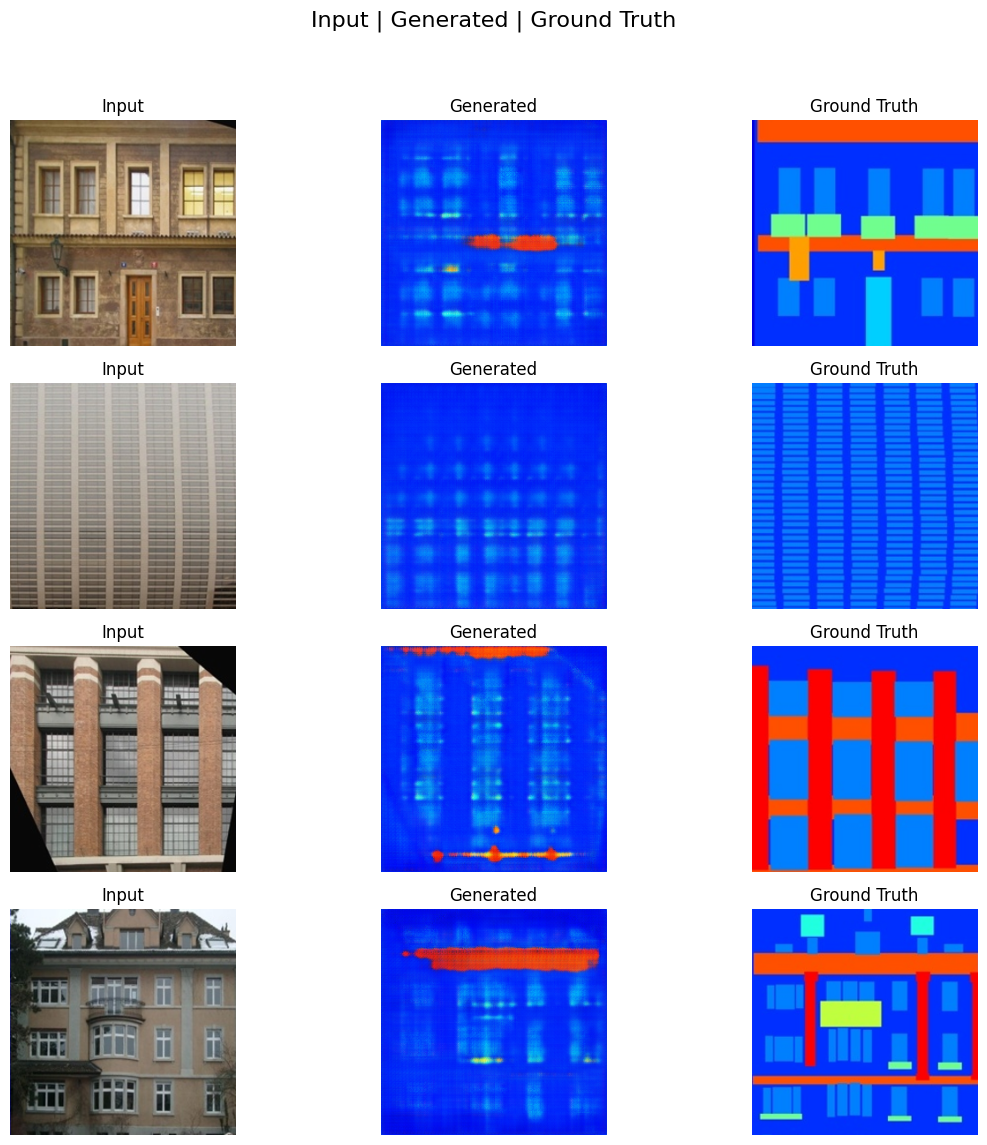

In [17]:
def show_images(test_loader, generator, num_images=4):
    generator.eval()
    inputs, targets = next(iter(test_loader))
    inputs, targets = inputs.to(device), targets.to(device)

    with torch.no_grad():
        generated_images = generator(inputs)

    #Denormalizing images from [-1, 1] to [0, 1] for plotting
    inputs = (inputs * 0.5 + 0.5).cpu()
    targets = (targets * 0.5 + 0.5).cpu()
    generated_images = (generated_images * 0.5 + 0.5).cpu()

    fig, axes = plt.subplots(num_images, 3, figsize=(12, 12))
    fig.suptitle('Input | Generated | Ground Truth', fontsize=16)
    
    for i in range(num_images):
        axes[i, 0].imshow(inputs[i].permute(1, 2, 0))
        axes[i, 0].set_title("Input")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(generated_images[i].permute(1, 2, 0))
        axes[i, 1].set_title("Generated")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(targets[i].permute(1, 2, 0))
        axes[i, 2].set_title("Ground Truth")
        axes[i, 2].axis('off')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

#Displaying results from the test set
show_images(test_loader, gen)